In [0]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras import regularizers
import tensorflow as tf
import os
import glob
from tqdm import tqdm
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
train_data_dir = '/content/drive/My Drive/train_capsnet/'
img_height, img_width = 800, 800
batch_size = 10
IMG_SIZE = 800

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    classes=['one-person', 'more-than-one']
    ) # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    classes=['one-person', 'more-than-one']
    ) # set as validation data

Found 0 images belonging to 2 classes.
Found 4391 images belonging to 2 classes.


In [0]:
input_image = Input(shape=(None, None, 3))


# A InceptionResNetV2 Conv2D model
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_image)

base_model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [0]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_image, outputs=output)


model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [0]:
for i, layer in enumerate(model.layers):
    if i < 15:
        layer.trainable = False
    else:
        layer.trainable = True

In [0]:
lr=1e-4

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])

In [0]:
early = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

callback_list = [checkpoint, early]

In [0]:
filepath = '/content/drive/My Drive/Colab Notebooks/model_states'

In [0]:
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath = filepath + 'my_model.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
lr=1e-4

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=lr), metrics=['accuracy'])

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 20,
    callbacks=my_callbacks,
    verbose=1)


Epoch 1/20
 561/1757 [========>.....................] - ETA: 1:32:27 - loss: 0.5905 - accuracy: 0.6829

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 840 could not be retrieved. It could be because a worker has died.
  UserWarning)


1757/1757 [==============================] - 10090s 6s/step - loss: 0.5275 - accuracy: 0.7344 - val_loss: 0.1938 - val_accuracy: 0.7927

Epoch 00001: val_loss improved from inf to 0.19380, saving model to /content/drive/My Drive/Colab Notebooks/model_statesmy_model.h5
Epoch 2/20
1757/1757 [==============================] - 2962s 2s/step - loss: 0.4178 - accuracy: 0.8151 - val_loss: 0.8758 - val_accuracy: 0.8263

Epoch 00002: val_loss did not improve from 0.19380
Epoch 3/20
1757/1757 [==============================] - 2907s 2s/step - loss: 0.3694 - accuracy: 0.8426 - val_loss: 0.8292 - val_accuracy: 0.7745

Epoch 00003: val_loss did not improve from 0.19380
Epoch 4/20
1757/1757 [==============================] - 3121s 2s/step - loss: 0.3453 - accuracy: 0.8558 - val_loss: 0.2374 - val_accuracy: 0.8357

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00004: val_loss did not improve from 0.19380
Epoch 5/20
1757/1757 [==============================] - 3171s 2s/step - 

KeyboardInterrupt: ignored

## Data with overlapped objects

In [0]:
img_height, img_width = 800, 800
batch_size = 14

In [0]:
train_folder = '/content/drive/My Drive/sort/train'
validation_folder = '/content/drive/My Drive/sort/validation/'

In [0]:
train_datagen = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range=0.2,
                    zoom_range=0.2
                    
                    )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 rescale=1./255,
                                 rotation_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True
                               )

In [0]:
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=['one-person', 'more-than-one']
    ) # set as training data

validation_generator = val_datagen.flow_from_directory(
    validation_folder, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='binary',
    classes=['one-person', 'more-than-one']
    ) # set as validation data

Found 6733 images belonging to 2 classes.
Found 1675 images belonging to 2 classes.


In [0]:
test_generator = test_datagen.flow_from_directory(
                    '/content/drive/My Drive/sort/test',
                    target_size=(img_height, img_width),
                    batch_size=30,
                    shuffle=True,
                    class_mode='binary',
                    classes=['one-person', 'more-than-one'])

Found 1117 images belonging to 2 classes.


In [0]:
my_callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.000001, verbose=1),
    ModelCheckpoint(filepath = '/content/drive/My Drive/Colab Notebooks/capsoverlap1.h5', 
    verbose=1, save_best_only=True, save_weights_only=False) 
    ]

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/weightscnn/cnnavatars091.h5')

In [0]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 10,
    callbacks=my_callbacks)

Epoch 1/10
479/480 [============================>.] - ETA: 11s - loss: 0.3666 - accuracy: 0.8543

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 21 could not be retrieved. It could be because a worker has died.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


480/480 [==============================] - 7293s 15s/step - loss: 0.3670 - accuracy: 0.8541 - val_loss: 0.2292 - val_accuracy: 0.8703

Epoch 00001: val_loss improved from inf to 0.22918, saving model to /content/drive/My Drive/Colab Notebooks/capsoverlap1.h5
Epoch 2/10
480/480 [==============================] - 1693s 4s/step - loss: 0.3261 - accuracy: 0.8732 - val_loss: 0.0781 - val_accuracy: 0.8525

Epoch 00002: val_loss improved from 0.22918 to 0.07815, saving model to /content/drive/My Drive/Colab Notebooks/capsoverlap1.h5
Epoch 3/10
480/480 [==============================] - 1681s 4s/step - loss: 0.2968 - accuracy: 0.8827 - val_loss: 0.3957 - val_accuracy: 0.8031

Epoch 00003: val_loss did not improve from 0.07815
Epoch 4/10
480/480 [==============================] - 1668s 3s/step - loss: 0.2881 - accuracy: 0.8882 - val_loss: 0.3267 - val_accuracy: 0.8531

Epoch 00004: val_loss did not improve from 0.07815
Epoch 5/10
480/480 [==============================] - 1663s 3s/step - loss: 

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/capsoverlap1.h5')

In [0]:
model.evaluate_generator(test_generator, test_generator.samples // 30)

[0.6269468665122986, 0.8315315246582031]

In [0]:
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

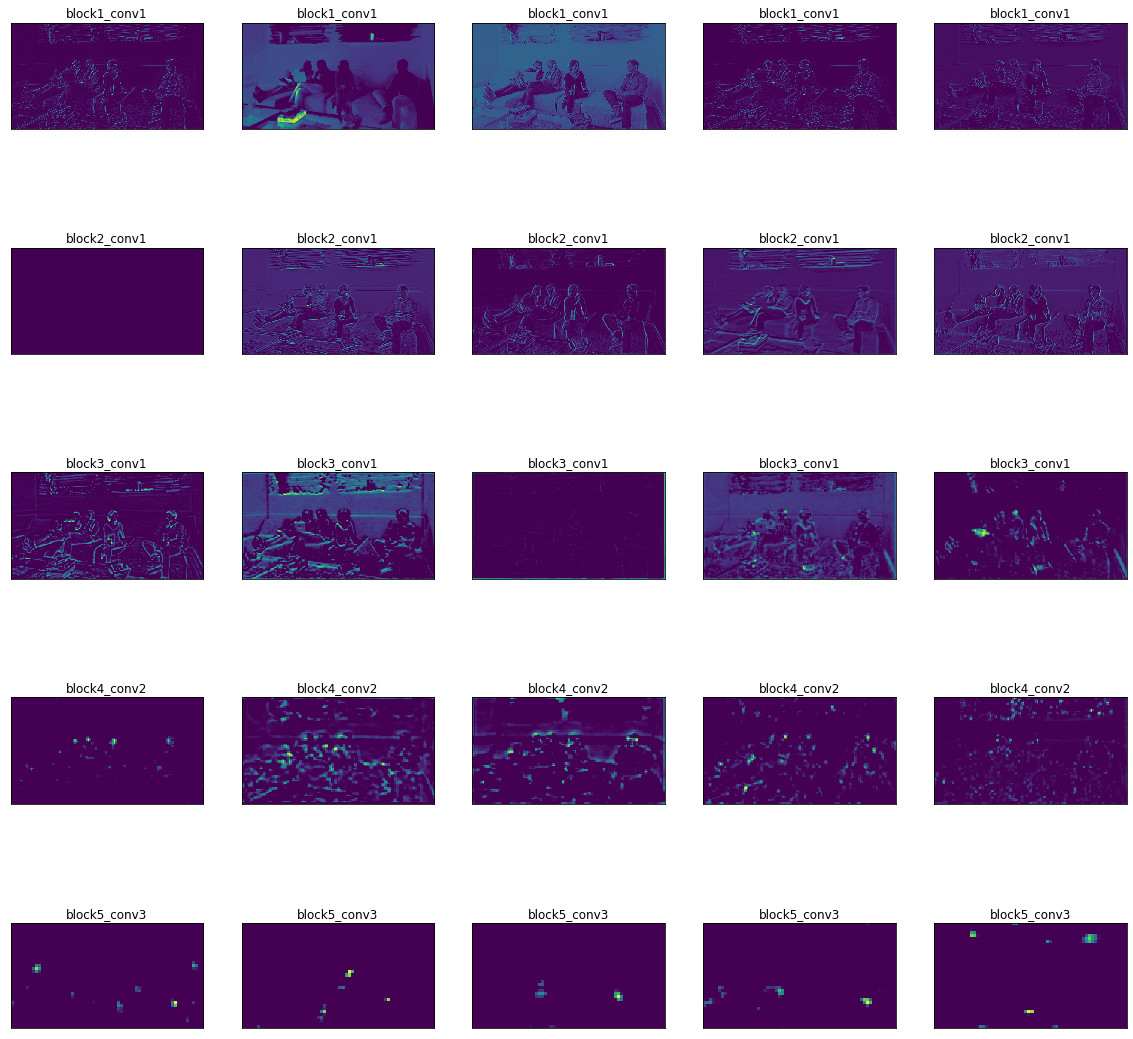

In [0]:
#importing required libraries and functions
from keras.models import Model
#defining names of layers from which we will take the output
layer_names = ['block1_conv1','block2_conv1','block3_conv1','block4_conv2', 'block5_conv3']
outputs = []
#read the image
image = cv2.imread('img5.jpeg')

image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#extracting the output and appending to outputs
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(image)
    outputs.append(intermediate_output)
#plotting the outputs
fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(20,20))

for i in range(5):
    for z in range(5):
        ax[i][z].imshow(outputs[i][0,:,:,z])
        ax[i][z].set_title(layer_names[i])
        ax[i][z].set_xticks([])
        ax[i][z].set_yticks([])
plt.savefig('in.jpg')